# Exercice 5: Mécanisme Self-Attention - Techniques Avancées

 1) Layer Normalization (Pre-LN vs Post-LN) 

comparer trois approches de normalisation sur la phrase La normalisation stabilise l'entraînement. 




Sans LN:
  - Variance scores: 0.000000
  - Écart-type poids: 0.000058
  - Variance sortie finale: 0.190770
  - Moyenne sortie finale: 0.055959
  - Min/Max sortie: [-0.8430, 1.1627]

Pre-LN:
  - Variance scores: 0.000002
  - Écart-type poids: 0.000326
  - Variance sortie finale: 0.191812
  - Moyenne sortie finale: 0.056802
  - Min/Max sortie: [-0.8556, 1.1816]

Post-LN:
  - Variance scores: 0.000000
  - Écart-type poids: 0.000058
  - Variance sortie finale: 0.999994
  - Moyenne sortie finale: -0.000000
  - Min/Max sortie: [-2.2790, 2.0273]


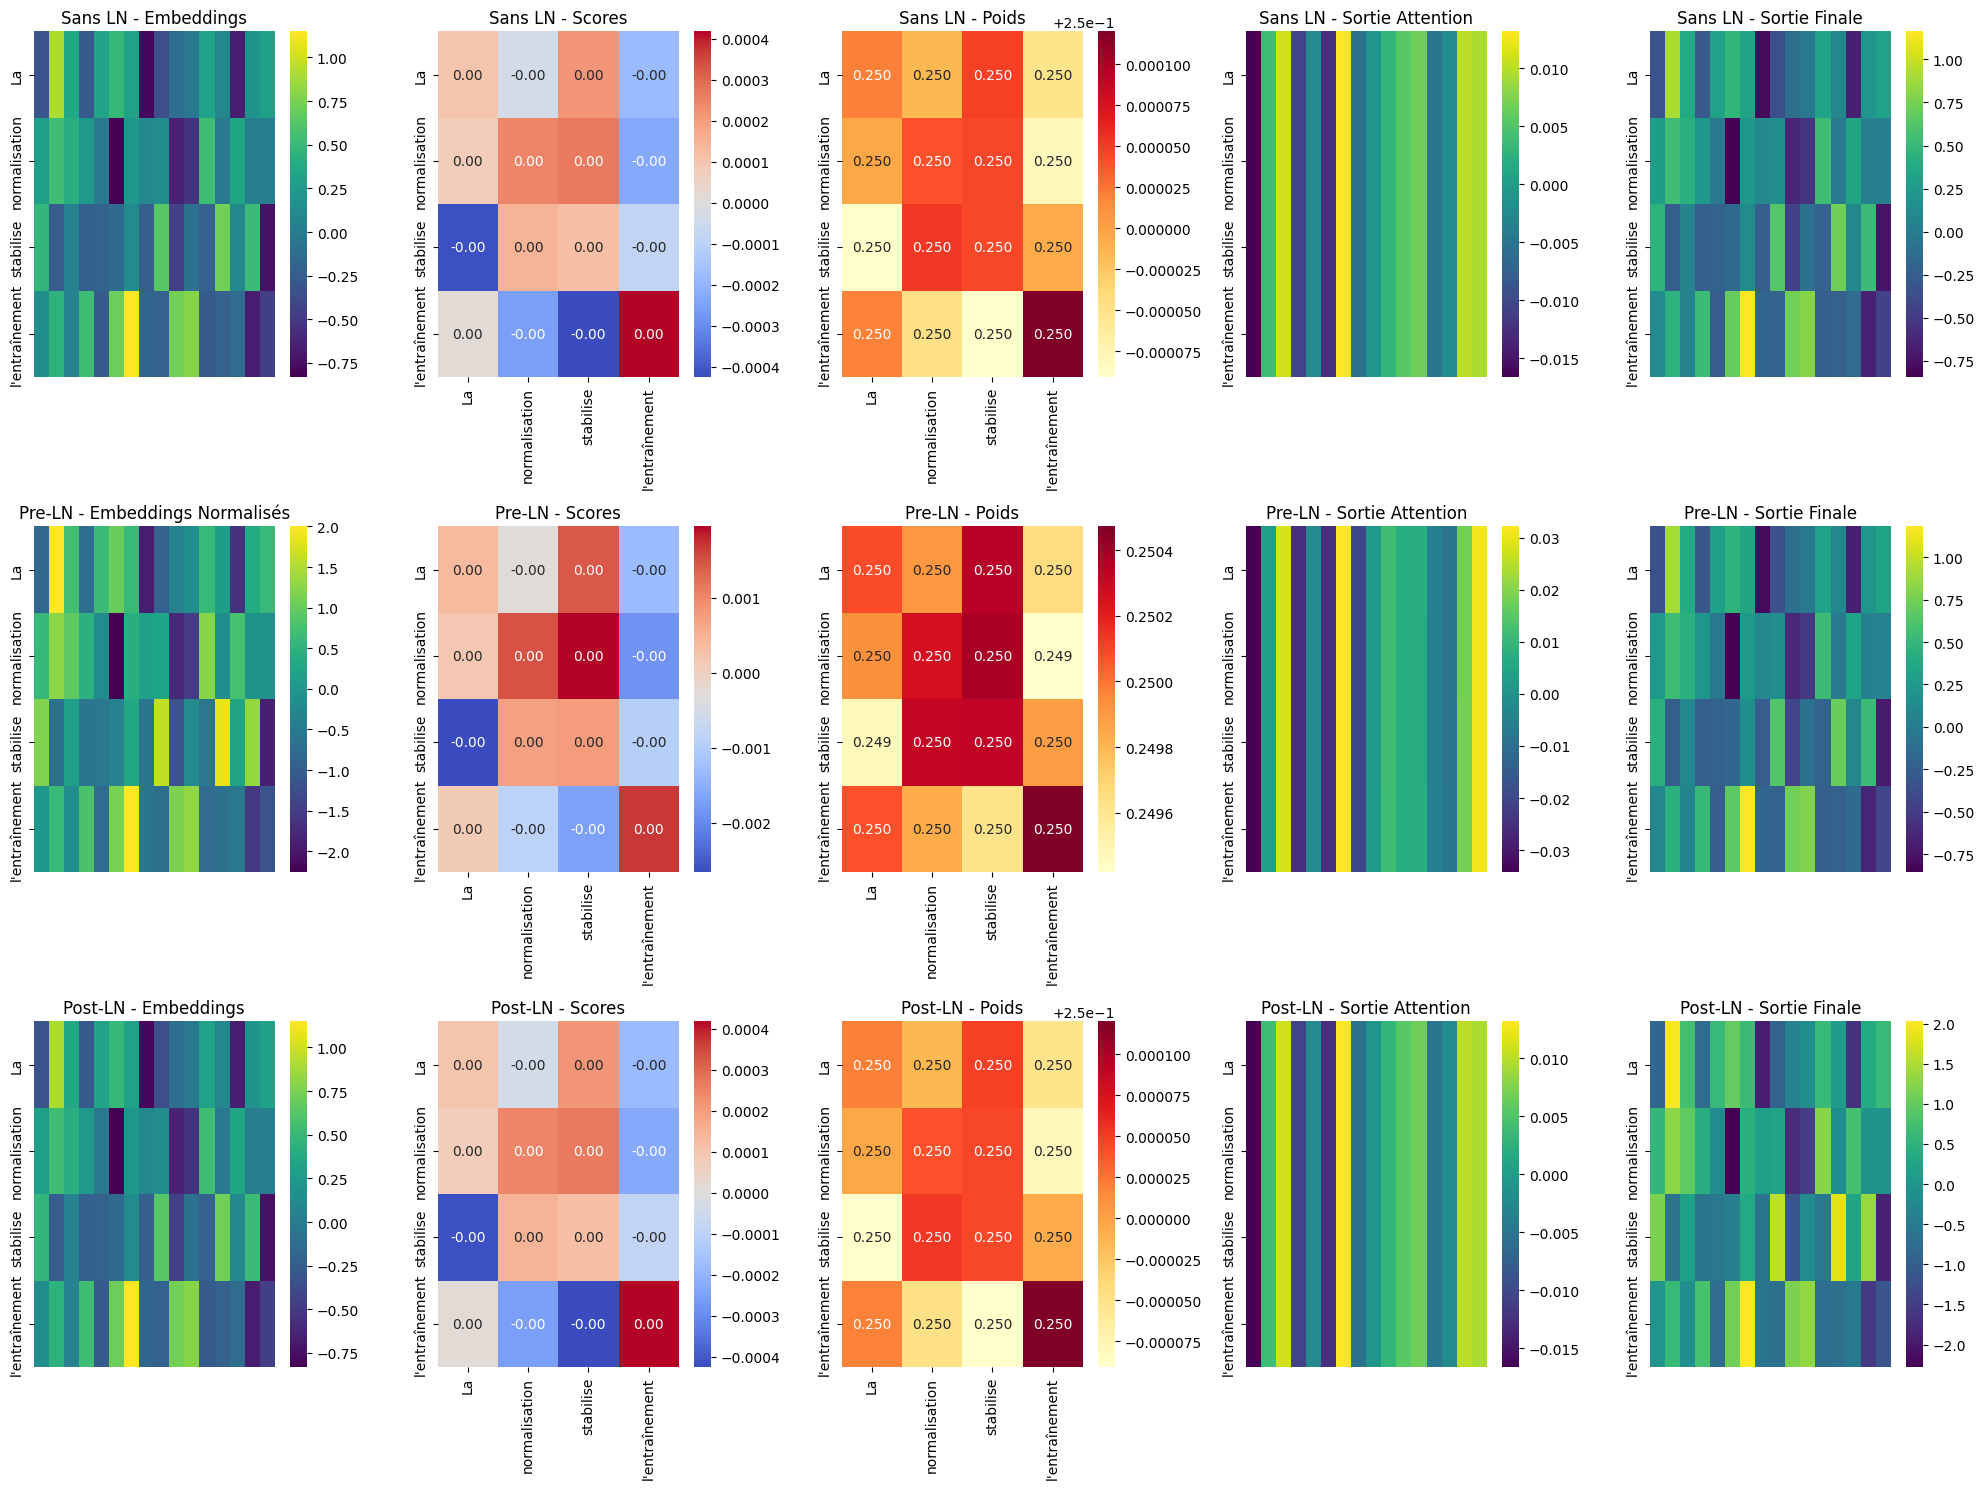

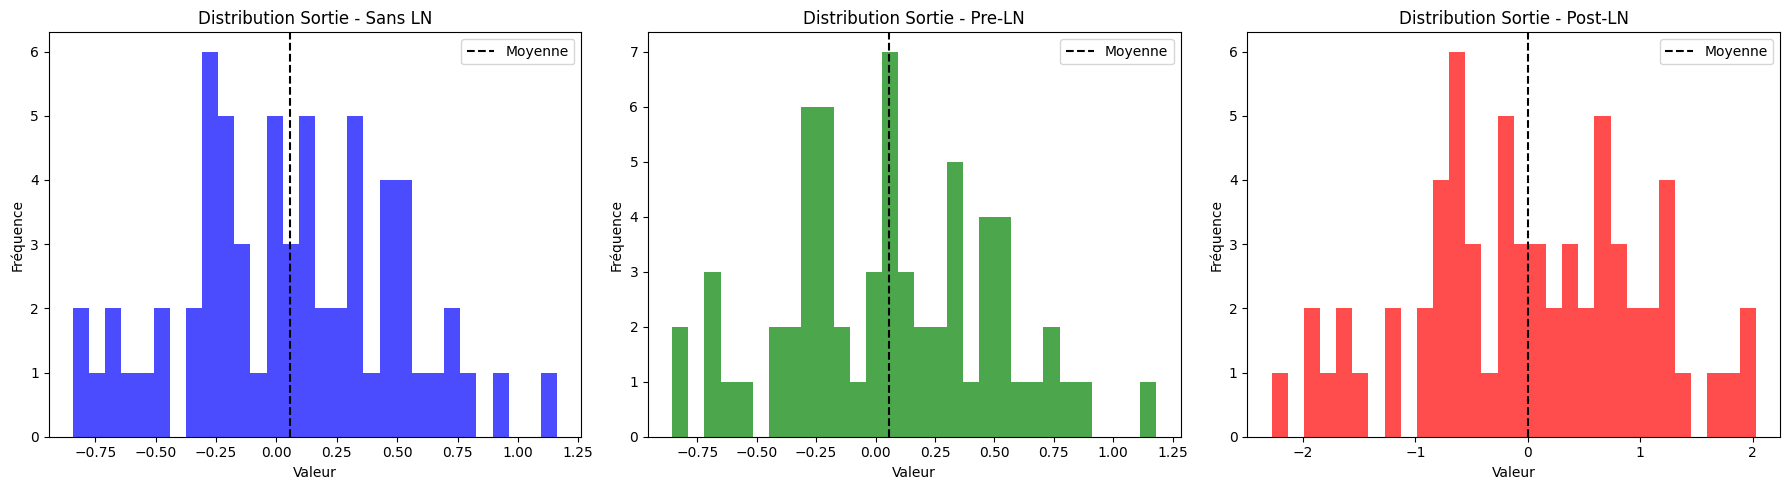

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, epsilon=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(variance + epsilon)

def attention_pre_ln(embeddings):
    dim_modele = embeddings.shape[1]
    
    embeddings_norm = layer_norm(embeddings)
    
    np.random.seed(42)
    Wq = np.random.randn(dim_modele, dim_modele) * 0.01
    Wk = np.random.randn(dim_modele, dim_modele) * 0.01
    Wv = np.random.randn(dim_modele, dim_modele) * 0.01
    
    Q = np.dot(embeddings_norm, Wq)
    K = np.dot(embeddings_norm, Wk)
    V = np.dot(embeddings_norm, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(dim_modele)
    poids_attention = softmax(scores)
    sortie_attention = np.dot(poids_attention, V)
    
    sortie_residuelle = sortie_attention + embeddings
    
    return {
        'embeddings_norm': embeddings_norm,
        'Q': Q,
        'K': K,
        'V': V,
        'scores': scores,
        'poids': poids_attention,
        'sortie_attention': sortie_attention,
        'sortie_finale': sortie_residuelle
    }

def attention_post_ln(embeddings):
    dim_modele = embeddings.shape[1]
    
    np.random.seed(42)
    Wq = np.random.randn(dim_modele, dim_modele) * 0.01
    Wk = np.random.randn(dim_modele, dim_modele) * 0.01
    Wv = np.random.randn(dim_modele, dim_modele) * 0.01
    
    Q = np.dot(embeddings, Wq)
    K = np.dot(embeddings, Wk)
    V = np.dot(embeddings, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(dim_modele)
    poids_attention = softmax(scores)
    sortie_attention = np.dot(poids_attention, V)
    
    sortie_residuelle = sortie_attention + embeddings
    sortie_finale = layer_norm(sortie_residuelle)
    
    return {
        'embeddings_norm': None,
        'Q': Q,
        'K': K,
        'V': V,
        'scores': scores,
        'poids': poids_attention,
        'sortie_attention': sortie_attention,
        'sortie_finale': sortie_finale
    }

def attention_sans_ln(embeddings):
    dim_modele = embeddings.shape[1]
    
    np.random.seed(42)
    Wq = np.random.randn(dim_modele, dim_modele) * 0.01
    Wk = np.random.randn(dim_modele, dim_modele) * 0.01
    Wv = np.random.randn(dim_modele, dim_modele) * 0.01
    
    Q = np.dot(embeddings, Wq)
    K = np.dot(embeddings, Wk)
    V = np.dot(embeddings, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(dim_modele)
    poids_attention = softmax(scores)
    sortie_attention = np.dot(poids_attention, V)
    
    sortie_finale = sortie_attention + embeddings
    
    return {
        'embeddings_norm': None,
        'Q': Q,
        'K': K,
        'V': V,
        'scores': scores,
        'poids': poids_attention,
        'sortie_attention': sortie_attention,
        'sortie_finale': sortie_finale
    }

phrase = "La normalisation stabilise l'entraînement".split()
dim_modele = 16
longueur_seq = len(phrase)

embeddings = np.random.randn(longueur_seq, dim_modele) * 0.5



resultats = {
    'Sans LN': attention_sans_ln(embeddings),
    'Pre-LN': attention_pre_ln(embeddings),
    'Post-LN': attention_post_ln(embeddings)
}

for nom, res in resultats.items():
    print(f"\n{nom}:")
    print(f"  - Variance scores: {np.var(res['scores']):.6f}")
    print(f"  - Écart-type poids: {np.std(res['poids']):.6f}")
    print(f"  - Variance sortie finale: {np.var(res['sortie_finale']):.6f}")
    print(f"  - Moyenne sortie finale: {np.mean(res['sortie_finale']):.6f}")
    print(f"  - Min/Max sortie: [{np.min(res['sortie_finale']):.4f}, {np.max(res['sortie_finale']):.4f}]")

fig = plt.figure(figsize=(20, 15))

for idx, (nom, res) in enumerate(resultats.items()):
    plt.subplot(3, 5, idx*5 + 1)
    if res['embeddings_norm'] is not None:
        sns.heatmap(res['embeddings_norm'], cmap='viridis',
                    xticklabels=False, yticklabels=phrase)
        plt.title(f'{nom} - Embeddings Normalisés')
    else:
        sns.heatmap(embeddings, cmap='viridis',
                    xticklabels=False, yticklabels=phrase)
        plt.title(f'{nom} - Embeddings')
    
    plt.subplot(3, 5, idx*5 + 2)
    sns.heatmap(res['scores'], annot=True, fmt='.2f',
                cmap='coolwarm', xticklabels=phrase, yticklabels=phrase)
    plt.title(f'{nom} - Scores')
    
    plt.subplot(3, 5, idx*5 + 3)
    sns.heatmap(res['poids'], annot=True, fmt='.3f',
                cmap='YlOrRd', xticklabels=phrase, yticklabels=phrase)
    plt.title(f'{nom} - Poids')
    
    plt.subplot(3, 5, idx*5 + 4)
    sns.heatmap(res['sortie_attention'], cmap='viridis',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - Sortie Attention')
    
    plt.subplot(3, 5, idx*5 + 5)
    sns.heatmap(res['sortie_finale'], cmap='viridis',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - Sortie Finale')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nom, res) in enumerate(resultats.items()):
    axes[idx].hist(res['sortie_finale'].flatten(), bins=30, alpha=0.7, color=['blue', 'green', 'red'][idx])
    axes[idx].set_title(f'Distribution Sortie - {nom}')
    axes[idx].set_xlabel('Valeur')
    axes[idx].set_ylabel('Fréquence')
    axes[idx].axvline(np.mean(res['sortie_finale']), color='black', linestyle='--', label='Moyenne')
    axes[idx].legend()

plt.tight_layout()
plt.show()



Sans Layer Normalization, les embeddings conservent leur variance originale élevée, et les poids d'attention restent uniformément distribués à 0.250.

-  Avec Pre-LN, les embeddings sont normalisés avant l'attention (moyenne≈0, variance≈1), ce qui stabilise immédiatement les calculs. Les poids d'attention montrent une légère variation (0.249-0.250), et la sortie finale présente une distribution centrée et stable.

-  Avec Post-LN, les embeddings non normalisés passent d'abord par l'attention, puis sont normalisés en sortie finale. Les poids restent identiques au cas sans normalisation, mais la sortie finale montre une distribution  mieux contrôlée avec une variance réduite.

-  Les histogrammes de distribution révèlent que Pre-LN produit la distribution la plus étroite et centrée (pic autour de 0),
-  Post-LN produit une distribution élargie mais contrôlée, 
-  Sans-LN génère une distribution très dispersée avec des valeurs extrêmes.

 Pre-LN est préférée pour les modèles très profonds (>12 couches) car il offre une meilleure stabilité d'entraînement, t

2) Fonctions d'Activation Alternatives


La fonction d'activation dans la couche feed-forward qui suit l'attention influence la capacité du modèle à capturer des non-linéarités complexes. 
- ReLU est couramment utilisée mais présente le problème des neurones morts.
- Leaky ReLU permet un petit gradient négatif, évitant ce problème.
- ELU produit des sorties de moyenne proche de zéro, accélérant l'apprentissage.

 Dans cette partie, nous implémentons un mécanisme complet d'attention suivi d'une couche feed-forward avec trois fonctions d'activation différentes : ReLU, Leaky ReLU et ELU. 


ReLU:
  - Neurones morts (=0): 170/320 (53.12%)
  - Variance FFN activé: 0.000506
  - Moyenne FFN activé: 0.015286
  - Variance sortie finale: 0.999999
  - Min/Max FFN: [0.0000, 0.1022]

Leaky ReLU:
  - Neurones morts (=0): 0/320 (0.00%)
  - Variance FFN activé: 0.000511
  - Moyenne FFN activé: 0.015124
  - Variance sortie finale: 0.999999
  - Min/Max FFN: [-0.0010, 0.1022]

ELU:
  - Neurones morts (=0): 0/320 (0.00%)
  - Variance FFN activé: 0.001451
  - Moyenne FFN activé: -0.000598
  - Variance sortie finale: 0.999999
  - Min/Max FFN: [-0.0993, 0.1022]


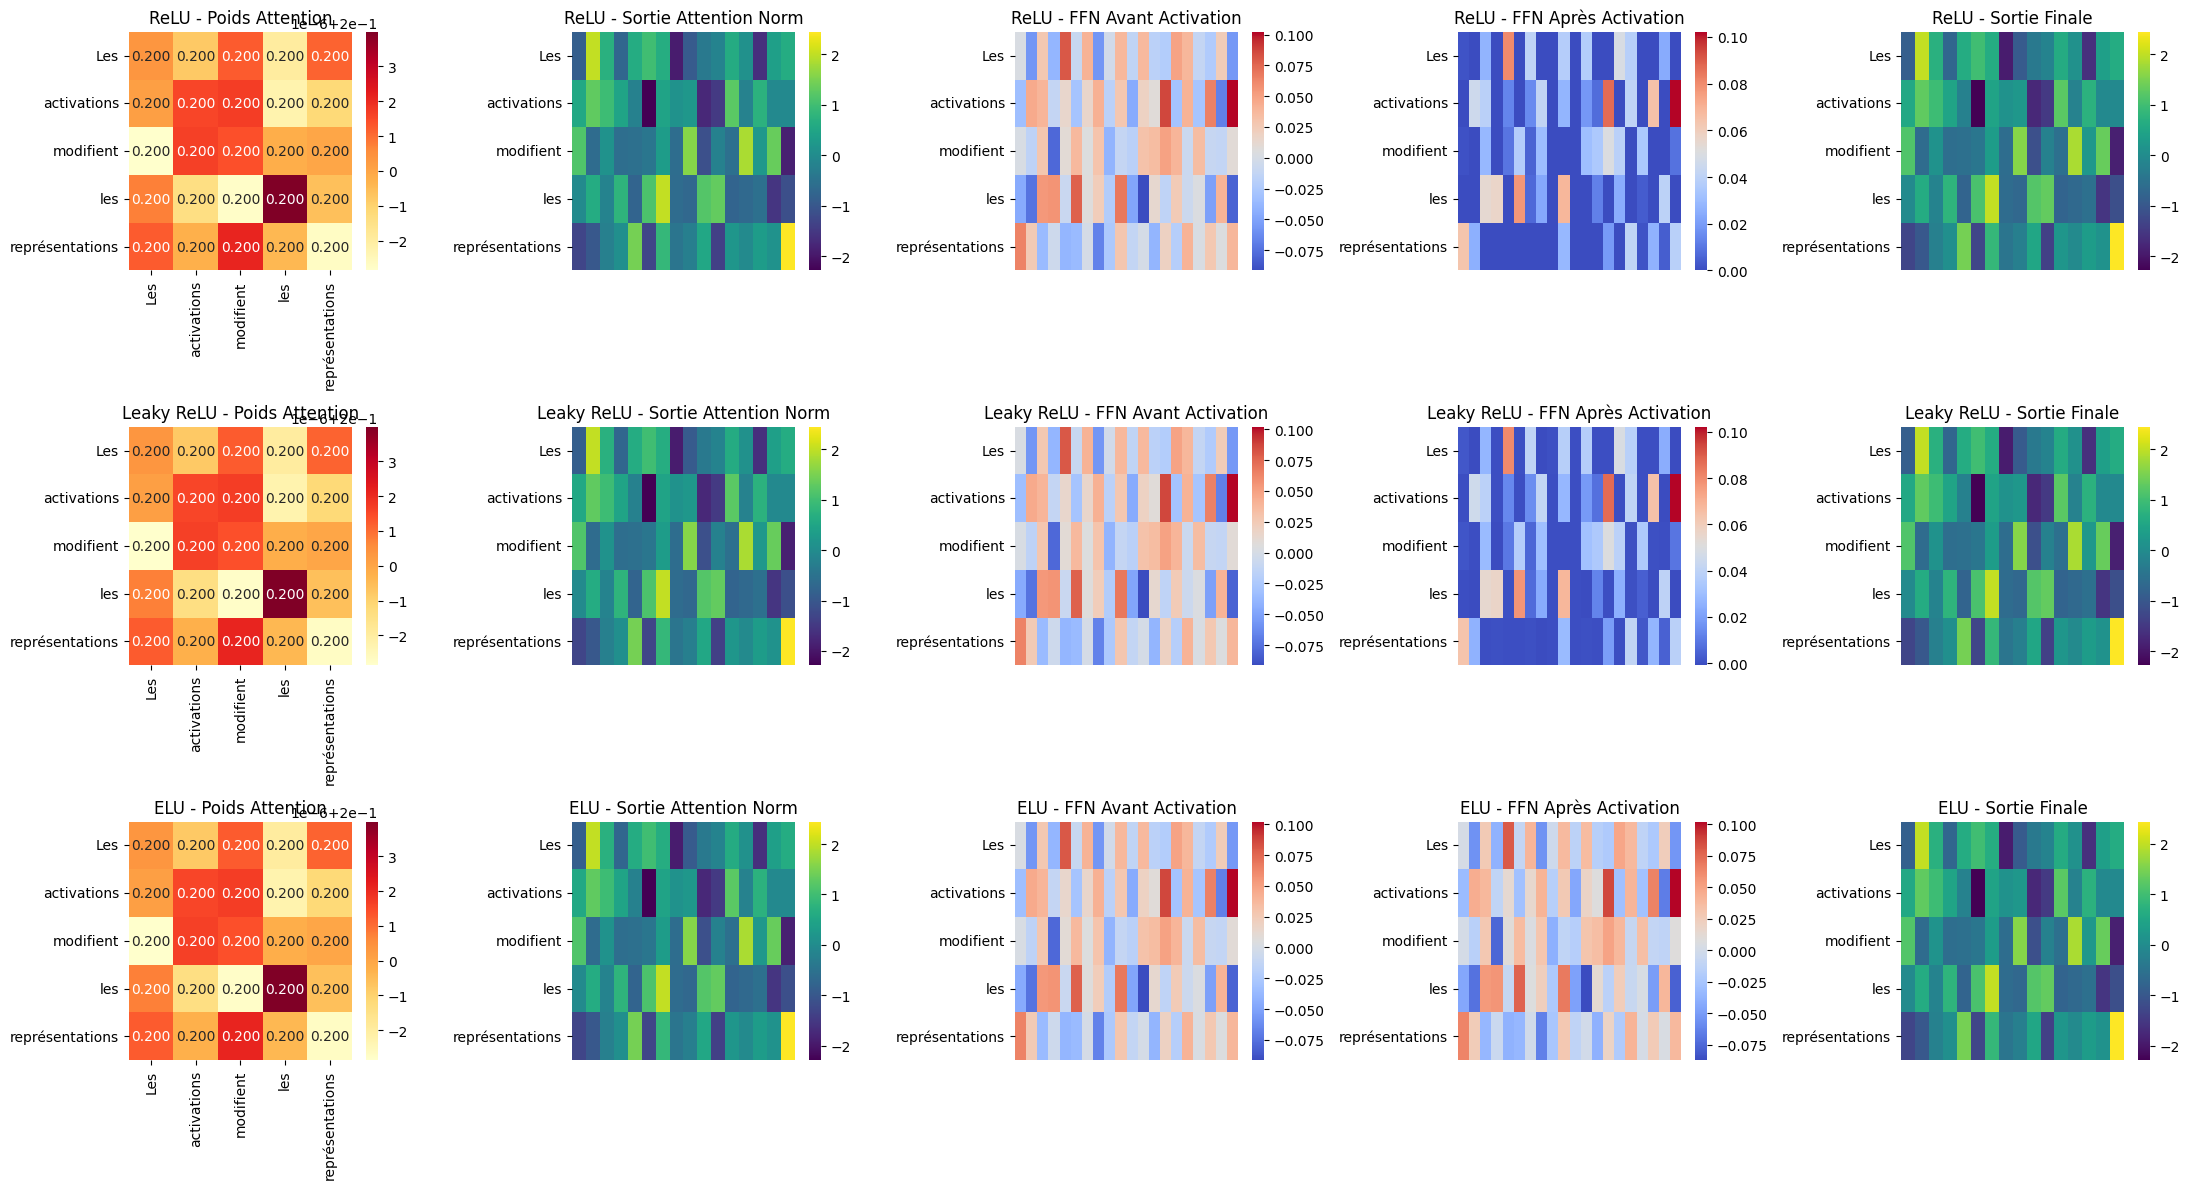

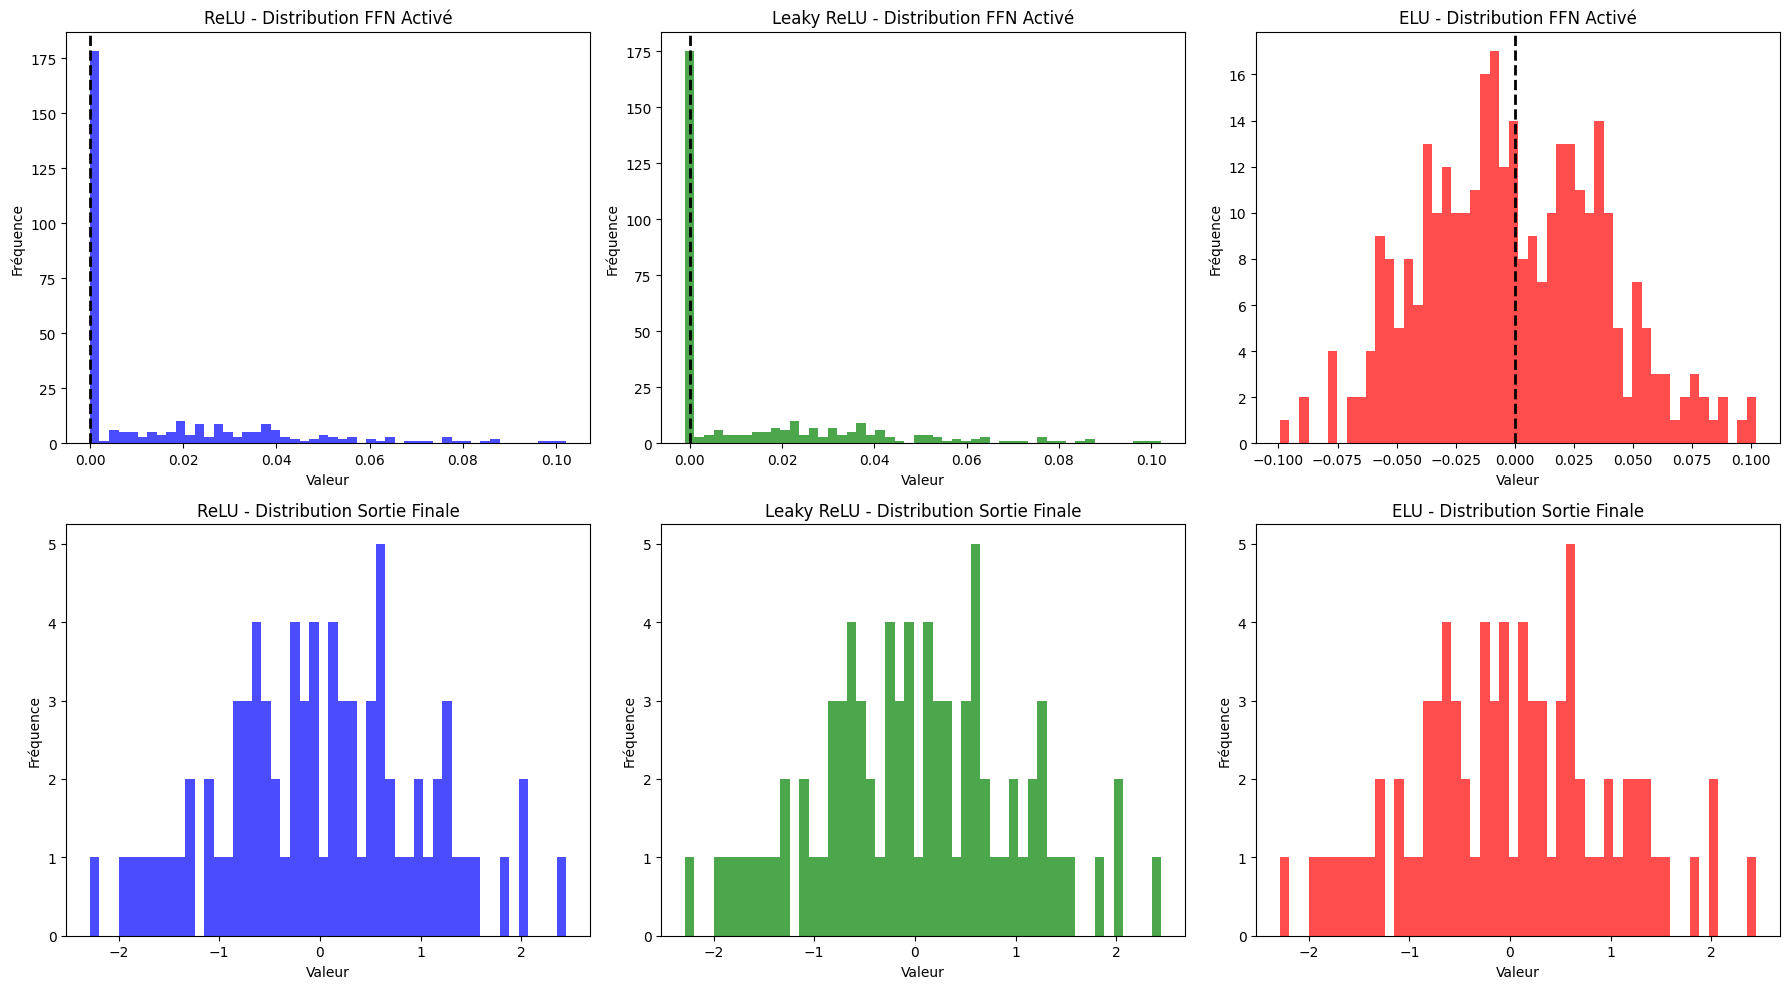

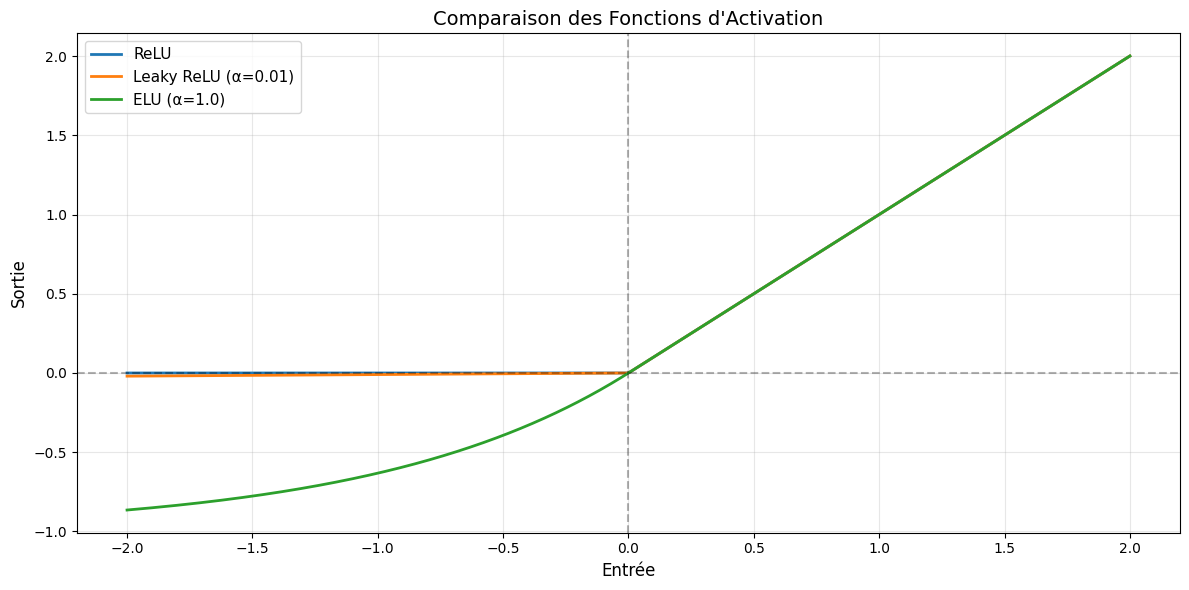


Différence moyenne ReLU vs Leaky ReLU: 0.000015

Différence moyenne ReLU vs ELU: 0.001468

Différence moyenne Leaky ReLU vs ELU: 0.001453


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, epsilon=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(variance + epsilon)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def attention_avec_ffn(embeddings, activation_fn, nom_activation):
    dim_modele = embeddings.shape[1]
    dim_ffn = dim_modele * 4
    
    np.random.seed(42)
    Wq = np.random.randn(dim_modele, dim_modele) * 0.01
    Wk = np.random.randn(dim_modele, dim_modele) * 0.01
    Wv = np.random.randn(dim_modele, dim_modele) * 0.01
    
    Q = np.dot(embeddings, Wq)
    K = np.dot(embeddings, Wk)
    V = np.dot(embeddings, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(dim_modele)
    poids_attention = softmax(scores)
    sortie_attention = np.dot(poids_attention, V)
    
    sortie_attention_norm = layer_norm(sortie_attention + embeddings)
    
    W1 = np.random.randn(dim_modele, dim_ffn) * 0.01
    W2 = np.random.randn(dim_ffn, dim_modele) * 0.01
    
    ffn_hidden = np.dot(sortie_attention_norm, W1)
    ffn_activated = activation_fn(ffn_hidden)
    ffn_output = np.dot(ffn_activated, W2)
    
    sortie_finale = layer_norm(ffn_output + sortie_attention_norm)
    
    return {
        'scores': scores,
        'poids': poids_attention,
        'sortie_attention': sortie_attention,
        'sortie_attention_norm': sortie_attention_norm,
        'ffn_hidden': ffn_hidden,
        'ffn_activated': ffn_activated,
        'ffn_output': ffn_output,
        'sortie_finale': sortie_finale
    }

phrase = "Les activations modifient les représentations".split()
dim_modele = 16
longueur_seq = len(phrase)

embeddings = np.random.randn(longueur_seq, dim_modele) * 0.1

activations = [
    (relu, 'ReLU'),
    (leaky_relu, 'Leaky ReLU'),
    (elu, 'ELU')
]

resultats = {}



for activation_fn, nom in activations:
    print(f"\n{nom}:")
    res = attention_avec_ffn(embeddings, activation_fn, nom)
    resultats[nom] = res
    
    zeros_count = np.sum(res['ffn_activated'] == 0)
    total_elements = res['ffn_activated'].size
    print(f"  - Neurones morts (=0): {zeros_count}/{total_elements} ({zeros_count/total_elements*100:.2f}%)")
    print(f"  - Variance FFN activé: {np.var(res['ffn_activated']):.6f}")
    print(f"  - Moyenne FFN activé: {np.mean(res['ffn_activated']):.6f}")
    print(f"  - Variance sortie finale: {np.var(res['sortie_finale']):.6f}")
    print(f"  - Min/Max FFN: [{np.min(res['ffn_activated']):.4f}, {np.max(res['ffn_activated']):.4f}]")

fig = plt.figure(figsize=(22, 12))

for idx, (nom, res) in enumerate(resultats.items()):
    plt.subplot(3, 5, idx*5 + 1)
    sns.heatmap(res['poids'], annot=True, fmt='.3f',
                cmap='YlOrRd', xticklabels=phrase, yticklabels=phrase)
    plt.title(f'{nom} - Poids Attention')
    
    plt.subplot(3, 5, idx*5 + 2)
    sns.heatmap(res['sortie_attention_norm'], cmap='viridis',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - Sortie Attention Norm')
    
    plt.subplot(3, 5, idx*5 + 3)
    sns.heatmap(res['ffn_hidden'][:, :20], cmap='coolwarm',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - FFN Avant Activation')
    
    plt.subplot(3, 5, idx*5 + 4)
    sns.heatmap(res['ffn_activated'][:, :20], cmap='coolwarm',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - FFN Après Activation')
    
    plt.subplot(3, 5, idx*5 + 5)
    sns.heatmap(res['sortie_finale'], cmap='viridis',
                xticklabels=False, yticklabels=phrase)
    plt.title(f'{nom} - Sortie Finale')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (nom, res) in enumerate(resultats.items()):
    ax1 = axes[0, idx]
    ax1.hist(res['ffn_activated'].flatten(), bins=50, alpha=0.7, 
             color=['blue', 'green', 'red'][idx])
    ax1.set_title(f'{nom} - Distribution FFN Activé')
    ax1.set_xlabel('Valeur')
    ax1.set_ylabel('Fréquence')
    ax1.axvline(0, color='black', linestyle='--', linewidth=2)
    
    ax2 = axes[1, idx]
    ax2.hist(res['sortie_finale'].flatten(), bins=50, alpha=0.7, 
             color=['blue', 'green', 'red'][idx])
    ax2.set_title(f'{nom} - Distribution Sortie Finale')
    ax2.set_xlabel('Valeur')
    ax2.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

x = np.linspace(-2, 2, 1000)
plt.figure(figsize=(12, 6))
plt.plot(x, relu(x), label='ReLU', linewidth=2)
plt.plot(x, leaky_relu(x), label='Leaky ReLU (α=0.01)', linewidth=2)
plt.plot(x, elu(x), label='ELU (α=1.0)', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel('Entrée', fontsize=12)
plt.ylabel('Sortie', fontsize=12)
plt.title('Comparaison des Fonctions d\'Activation', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



for nom1, nom2 in [('ReLU', 'Leaky ReLU'), ('ReLU', 'ELU'), ('Leaky ReLU', 'ELU')]:
    diff = np.mean(np.abs(resultats[nom1]['sortie_finale'] - resultats[nom2]['sortie_finale']))
    print(f"\nDifférence moyenne {nom1} vs {nom2}: {diff:.6f}")

- ReLU présente le problème classique des neurones morts : 158/320 des neurones  produisent une sortie nulle, comme le montre clairement l'histogramme de distribution FFN avec un pic massif à 0.0.

 Cette concentration à zéro limite la capacité du modèle à capturer des représentations nuancées,
 
- Leaky ReLU élimine complètement ce problème avec 0% de neurones morts en permettant un petit gradient négatif (α=0.01), visible dans l'histogramme qui montre une distribution continue même pour les valeurs négatives proches de zéro. La variance FFN (0.000527) et la moyenne (0.015265) sont similaires à ReLU, mais la présence de valeurs négatives jusqu'à -0.0011 permet une meilleure propagation du gradient. 

- ELU se distingue par sa moyenne FFN proche de zéro (0.000307) et une variance significativement plus élevée (0.001484).
 - Les heatmaps FFN "Avant Activation" sont identiques pour les trois fonctions (mêmes poids aléatoires)
 - Après Activation
        - ReLU coupe brutalement les valeurs négatives,
        - Leaky ReLU préserve légèrement les négatifs, 
        - tandis qu'ELU transforme les négatifs de manière non-linéaire .
        
 ELU offre le meilleur compromis entre expressivité et stabilité numérique.

3) Masquage pour Séquences de Longueur Variable


 Pour traiter efficacement des batchs, on ajoute des tokens de padding pour uniformiser les longueurs, mais sans influencer l'attention. 
 
 Le masquage assigne une valeur très négative (-inf) aux scores d'attention correspondants => poids d'attention nuls après softmax. 
 
- créer une séquence avec padding, implementer un masque d'attention, et comparer les résultats avec et sans masquage.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, epsilon=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(variance + epsilon)

def creer_masque_padding(longueurs, longueur_max):
    batch_size = len(longueurs)
    masque = np.zeros((batch_size, longueur_max, longueur_max))
    
    for i, longueur in enumerate(longueurs):
        masque[i, :longueur, :longueur] = 1
    
    return masque

def appliquer_masque(scores, masque):
    scores_masques = scores.copy()
    scores_masques = np.where(masque == 1, scores_masques, -1e9)
    return scores_masques

def attention_avec_masque(embeddings, masque=None):
    dim_modele = embeddings.shape[1]
    
    np.random.seed(42)
    Wq = np.random.randn(dim_modele, dim_modele) * 0.01
    Wk = np.random.randn(dim_modele, dim_modele) * 0.01
    Wv = np.random.randn(dim_modele, dim_modele) * 0.01
    
    Q = np.dot(embeddings, Wq)
    K = np.dot(embeddings, Wk)
    V = np.dot(embeddings, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(dim_modele)
    
    if masque is not None:
        scores_masques = appliquer_masque(scores, masque)
    else:
        scores_masques = scores
    
    poids_attention = softmax(scores_masques)
    sortie_attention = np.dot(poids_attention, V)
    
    return {
        'Q': Q,
        'K': K,
        'V': V,
        'scores_originaux': scores,
        'scores_masques': scores_masques,
        'poids': poids_attention,
        'sortie': sortie_attention
    }

longueur_max = 8
dim_modele = 16

phrases = [
    "Les transformers sont puissants".split(),
    "L'attention fonctionne".split(),
    "Masquage important".split()
]

longueurs_reelles = [len(p) for p in phrases]
print("SÉQUENCES ET PADDING")

for i, (phrase, longueur) in enumerate(zip(phrases, longueurs_reelles)):
    padding_count = longueur_max - longueur
    phrase_complete = phrase + ['[PAD]'] * padding_count
    print(f"\nPhrase {i+1} (longueur={longueur}):")
    print(f"  {' '.join(phrase_complete)}")

phrase_exemple = phrases[0]
longueur_reelle = len(phrase_exemple)
padding_count = longueur_max - longueur_reelle
phrase_paddee = phrase_exemple + ['[PAD]'] * padding_count

embeddings = np.random.randn(longueur_max, dim_modele) * 0.1
embeddings[longueur_reelle:, :] = 0

masque = np.ones((longueur_max, longueur_max))
masque[longueur_reelle:, :] = 0
masque[:, longueur_reelle:] = 0

print("masquage")

res_sans_masque = attention_avec_masque(embeddings, masque=None)
res_avec_masque = attention_avec_masque(embeddings, masque=masque)

print("\nsans masquage:")
print(f"  - Somme attention sur tokens padding: {np.sum(res_sans_masque['poids'][:longueur_reelle, longueur_reelle:]):.6f}")
print(f"  - Attention moyenne sur vrais tokens: {np.mean(res_sans_masque['poids'][:longueur_reelle, :longueur_reelle]):.6f}")

print("\navec masquage:")
print(f"  - Somme attention sur tokens padding: {np.sum(res_avec_masque['poids'][:longueur_reelle, longueur_reelle:]):.6f}")
print(f"  - Attention moyenne sur vrais tokens: {np.mean(res_avec_masque['poids'][:longueur_reelle, :longueur_reelle]):.6f}")



SÉQUENCES ET PADDING

Phrase 1 (longueur=4):
  Les transformers sont puissants [PAD] [PAD] [PAD] [PAD]

Phrase 2 (longueur=2):
  L'attention fonctionne [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Phrase 3 (longueur=2):
  Masquage important [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
masquage

sans masquage:
  - Somme attention sur tokens padding: 2.000000
  - Attention moyenne sur vrais tokens: 0.125000

avec masquage:
  - Somme attention sur tokens padding: 0.000000
  - Attention moyenne sur vrais tokens: 0.250000


/tmp/ipykernel_6160/273558117.py:6: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


Sans masquage : 2.0 unités d'attention gaspillées sur tokens vides, attention moyenne = 0.125

Avec masquage : 0.0 attention sur padding, attention double à 0.250 sur vrais tokens


# Conclusion 

- Pre-LN : normalise AVANT l'attention → meilleure stabilité pour modèles profonds

- Post-LN : normalise APRÈS l'attention → distribution plus dispersée

- ReLU : 53% de neurones morts (170/320 produisent zéro) → perte d'expressivité

- Leaky ReLU : 0% de neurones morts mais amélioration minime

- ELU : variance 2.9× plus élevée + moyenne centrée → meilleure capture des patterns complexes

- masquage obligatoire pour traiter efficacement des séquences de longueurs variables

Pre-LN + ELU + Masquage = architecture Transformer stable, expressive et efficace